In [1]:
import numpy as np
import fixed_income_derivatives_E2025 as fid
from scipy.optimize import minimize
import matplotlib.pyplot as plt

EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate": 0.0430136}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.0455066},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.0477436},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.0497492},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.0515456},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.0531529},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.0545893},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.0558712},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.0570135},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.0580298}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.0558702, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.058811, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.0600937, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.0605263, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.0601899, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.0586669, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.0562267, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.0547351, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.0535523, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

mesh = 1/12
M = 360
T = np.array([mesh*i for i in range(0,M+1)])



In [2]:
# Problem 2
# Fitting ZCB spot- and forward rate curves
# interpolation_options = {"method":"linear"}
# interpolation_options = {"method":"nelson_siegel","transition": "smooth"}
interpolation_options = {"method":"hermite","degree":4,"transition": "smooth"}
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T,T_fit,R_fit,interpolation_options = interpolation_options)



In [3]:
# Fitting a Vasicek model to the yield curve
param_0 = 0.035, 0.5, 0.025, 0.03
result = minimize(fid.fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit: {result.x}. SSE of the fit: {result.fun}")
r0_vasicek, a_vasicek, b_vasicek, sigma_vasicek = result.x
p_vasicek = fid.zcb_price_vasicek(r0_vasicek,a_vasicek,b_vasicek,sigma_vasicek,T_inter)
f_vasicek = fid.forward_rate_vasicek(r0_vasicek,a_vasicek,b_vasicek,sigma_vasicek,T_inter)
R_vasicek = fid.spot_rate_vasicek(r0_vasicek,a_vasicek,b_vasicek,sigma_vasicek,T_inter)



Parameters from the fit: [ 3.06576455e-02  6.78010649e+00  3.67709491e-01 -2.49332927e-07]. SSE of the fit: 0.0037644410347581285


/var/folders/ch/svk174ms2t7404n3sl5_kg380000gn/T/ipykernel_44894/58074312.py:3: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fid.fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})


In [4]:
# Fitting a CIR model to the yield curve
param_0 = 0.035, 0.5, 0.05, 0.1
result = minimize(fid.fit_cir_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit: {result.x}. SSE of the fit: {result.fun}")
r0_cir, a_cir, b_cir, sigma_cir = result.x
p_cir = fid.zcb_price_cir(r0_cir,a_cir,b_cir,sigma_cir,T_inter)
f_cir = fid.forward_rate_cir(r0_cir,a_cir,b_cir,sigma_cir,T_inter)
R_cir = fid.spot_rate_cir(r0_cir,a_cir,b_cir,sigma_cir,T_inter)



Parameters from the fit: [ 3.06547925e-02  6.78142706e+00  5.42336547e-02 -7.99978437e-05]. SSE of the fit: 0.0037644155015281646


/var/folders/ch/svk174ms2t7404n3sl5_kg380000gn/T/ipykernel_44894/3112340663.py:3: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fid.fit_cir_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})


In [5]:
# Problem 4
# Fitting a Hull-White Extended Vasicek model to the data
T_star = np.array([mesh*i for i in range(0,M+1)])
f_fit = np.array(fid.for_values_in_list_find_value_return_value(T_fit,T_inter,f_inter))
f_star, f_T_star = fid.interpolate(T,T_fit,f_fit,interpolation_options)



In [6]:
# Problem 5
# Pricing an interest rate cap
strike = 0.06
alpha = 0.5
T_cap = 10
a = 0.15
sigma = 0.01
M_caplet = int(T_cap/alpha)
T_caplet = np.array([i*alpha for i in range(0,M_caplet+1)])
p_caplet = fid.for_values_in_list_find_value_return_value(T_caplet,T_inter,p_inter)
price_caplet = np.zeros([M_caplet+1])
for i in range(2,M_caplet+1):
    price_caplet[i] = (1 + (T_caplet[i]-T_caplet[i-1])*strike)*fid.euro_option_price_hwev(1/(1 + (T_caplet[i]-T_caplet[i-1])*strike),T_caplet[i-1],T_caplet[i],p_caplet[i-1],p_caplet[i],a,sigma,type_option = "put")
price_cap = sum(price_caplet[2:])
S_swap = fid.accrual_factor_from_zcb_prices(0,0,T_caplet[-1],"semiannual",T_caplet,p_caplet)
premium_cap = (price_cap/S_swap)
print(f"Caplet prices: {10000*price_caplet}")
print(f"price_cap: {10000*price_cap}, premium_cap: {10000*premium_cap}")
price_caplet_down = fid.caplet_prices_hwev(strike,a,sigma-0.001,T_caplet,p_caplet)
price_cap_down = sum(price_caplet_down[2:])
premium_cap_down = (price_cap_down/S_swap)
print(f"price_cap_down: {10000*price_cap_down}, premium_cap_down: {10000*premium_cap_down}")
price_caplet_up = fid.caplet_prices_hwev(strike,a,sigma+0.001,T_caplet,p_caplet)
price_cap_up = sum(price_caplet_up[2:])
premium_cap_up = (price_cap_up/S_swap)
print(f"price_cap_up: {10000*price_cap_up}, premium_cap_up: {10000*premium_cap_up}")



Caplet prices: [ 0.          0.          3.85913554 18.13443477 27.35145086 31.47825354
 32.28645449 31.36393344 29.66908881 27.47380483 25.22350474 22.86340995
 20.84326628 18.88933083 16.9206021  15.19524536 13.85802783 12.67416828
 11.58584457 10.55178609  9.55034188]
price_cap: 379.77208421588284, premium_cap: 50.69645986520679
price_cap_down: 341.802545908668, premium_cap_down: 45.627837776075246
price_cap_up: 418.0964017544378, premium_cap_up: 55.81244207323643


In [7]:
# Problem 6
# Simulation in the Hull-White Extended Vasicek model
M_simul, T_simul = 500, 30
size_ci = 0.95
mesh_simul = T_simul/M_simul
t_simul = np.array([i*mesh_simul for i in range(0,M_simul+1)])
np.random.seed(2)
f_market, f_T_market = fid.interpolate(t_simul,T_fit,f_fit,interpolation_options)
theta = fid.theta_hwev(t_simul,f_market,f_T_market,a,sigma)
r_simul = fid.simul_hwev(f_market[0],t_simul,theta,a,sigma,method = "euler")
mean_hwev, var_hwev = fid.mean_var_hwev(a,sigma,t_simul,f_market,f_T_market)
lb, ub = fid.ci_hwev(a,sigma,t_simul,f_market,f_T_market,size_ci,type_ci = "two_sided")



In [8]:
# Problem 7
# Pricing a 1Y10Y receiver swaption
strike = 0.06
T_n, T_N, alpha = 1, 11, 0.5
M_simul_swaption, N_simul_swaption = 1000, 5000
chi, price_swaption_simul, price_swaption_plot = np.zeros([N_simul_swaption]), np.zeros([N_simul_swaption]), np.zeros([N_simul_swaption])
mesh_simul_swaption = T_n/M_simul_swaption
t_swaption = np.array([i*mesh_simul_swaption for i in range(0,M_simul_swaption+1)])
f_swaption, f_T_swaption = fid.interpolate(t_swaption,T_fit,f_fit,interpolation_options)
f_star_t = fid.for_values_in_list_find_value_return_value(T_n,T_star,f_star)
T_swaption = np.array([i*alpha for i in range(int(T_n/alpha),int(T_N/alpha)+1)])
p_swaption = fid.zcb_price_hwev(T_n,T_swaption,0,a,sigma,T_inter,p_inter,f_star_t)
T_swap = np.array([i*alpha for i in range(0,int((T_N-T_n)/alpha)+1)])
B = (np.ones(len(T_swap)) - np.exp(-a*T_swap))/a
theta_swaption = fid.theta_hwev(t_swaption,f_swaption,f_T_swaption,a,sigma)
for i in range(0,N_simul_swaption):
    r_simul_swaption = fid.simul_hwev(f_swaption[0],t_swaption,theta_swaption,a,sigma,method = "euler",seed = None)
    p_swap = p_swaption.copy()
    for j in range(0,len(B)):
        p_swap[j] = p_swaption[j]*np.exp(-B[j]*r_simul_swaption[-1])
    R_swap, S_swap = fid.swap_rate_from_zcb_prices(0,0,T_N-T_n,"semiannual",T_swap,p_swap)
    chi[i] = max(strike-R_swap,0)*S_swap
    price_swaption_simul[i] = np.exp(-(T_n/M_simul_swaption)*sum(r_simul_swaption[0:M_simul_swaption]))*chi[i]
    price_swaption_plot[i] = sum(price_swaption_simul[0:i+1])/(i+1)*10000
print(f"price_swaption: {price_swaption_plot[-1]} bps")

price_swaption_explicit = fid.swaption_price_hwev(T_n,T_N,strike,"semiannual",f_star[0],a,sigma,T_star,p_inter,f_star,type_swap = "receiver")
print(f"price_swaption explicit: {10000*price_swaption_explicit}")


price_swaption: 215.81745830568192 bps
price_swaption explicit: 212.76482011523316


In [9]:

# Pricing a digital option
strike = 0.06
T_n, T_N, alpha = 1, 11, 0.5
M_simul_digital, N_simul_digital = 1000, 5000
chi, price_digital_simul, price_digital_plot = np.zeros([N_simul_digital]), np.zeros([N_simul_digital]), np.zeros([N_simul_digital])
mesh_simul_digital = T_n/M_simul_digital
t_digital = np.array([i*mesh_simul_digital for i in range(0,M_simul_digital+1)])
f_digital, f_T_digital = fid.interpolate(t_digital,T_fit,f_fit,interpolation_options)
f_star_t = fid.for_values_in_list_find_value_return_value(T_n,T_star,f_star)
T_digital = np.array([i*alpha for i in range(int(T_n/alpha),int(T_N/alpha)+1)])
p_digital = fid.zcb_price_hwev(T_n,T_digital,0,a,sigma,T_inter,p_inter,f_star_t)
T_swap = np.array([i*alpha for i in range(0,int((T_N-T_n)/alpha)+1)])
B = (np.ones(len(T_swap)) - np.exp(-a*T_swap))/a
theta_digital = fid.theta_hwev(t_digital,f_digital,f_T_digital,a,sigma)
for i in range(0,N_simul_digital):
    r_simul_digital = fid.simul_hwev(f_digital[0],t_digital,theta_digital,a,sigma,method = "euler",seed = None)
    p_swap = p_digital.copy()
    for j in range(0,len(B)):
        p_swap[j] = p_digital[j]*np.exp(-B[j]*r_simul_digital[-1])
    R_swap, S_swap = fid.swap_rate_from_zcb_prices(0,0,T_N-T_n,"annual",T_swap,p_swap)
    if R_swap > strike:
        chi[i] = 1
    price_digital_simul[i] = np.exp(-(T_n/M_simul_digital)*sum(r_simul_digital[0:M_simul_digital]))*chi[i]
    price_digital_plot[i] = sum(price_digital_simul[0:i+1])/(i+1)
print(f"price_digital: {price_digital_plot[-1]} as a fraction of the principal")



price_digital: 0.445739638340447 as a fraction of the principal


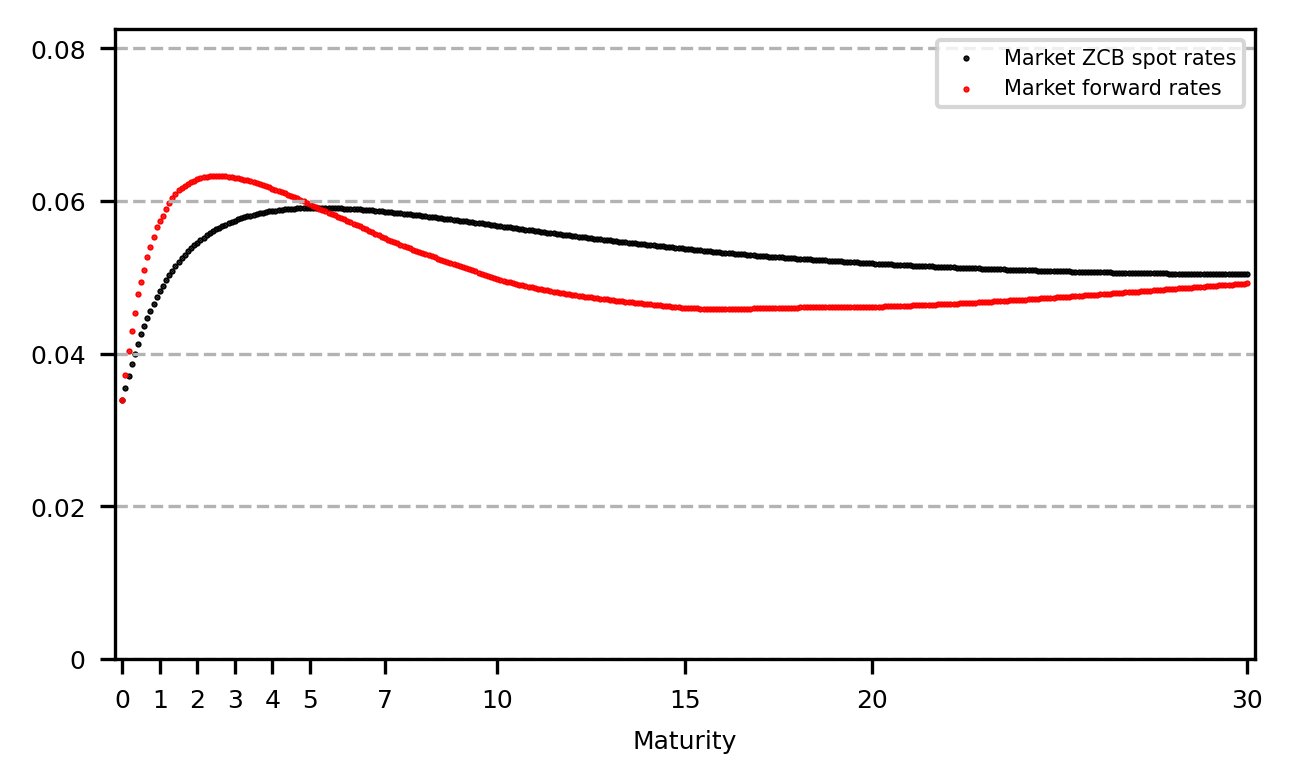

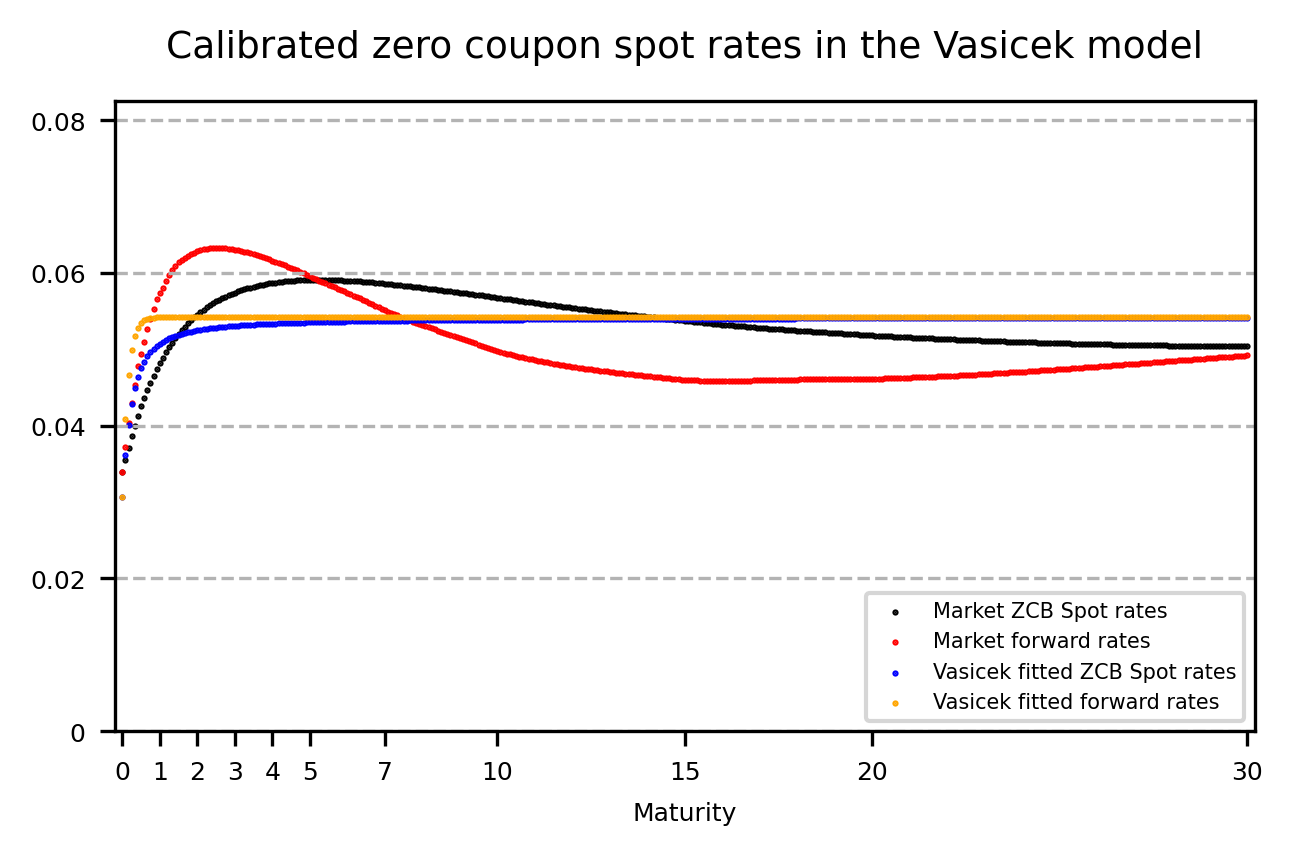

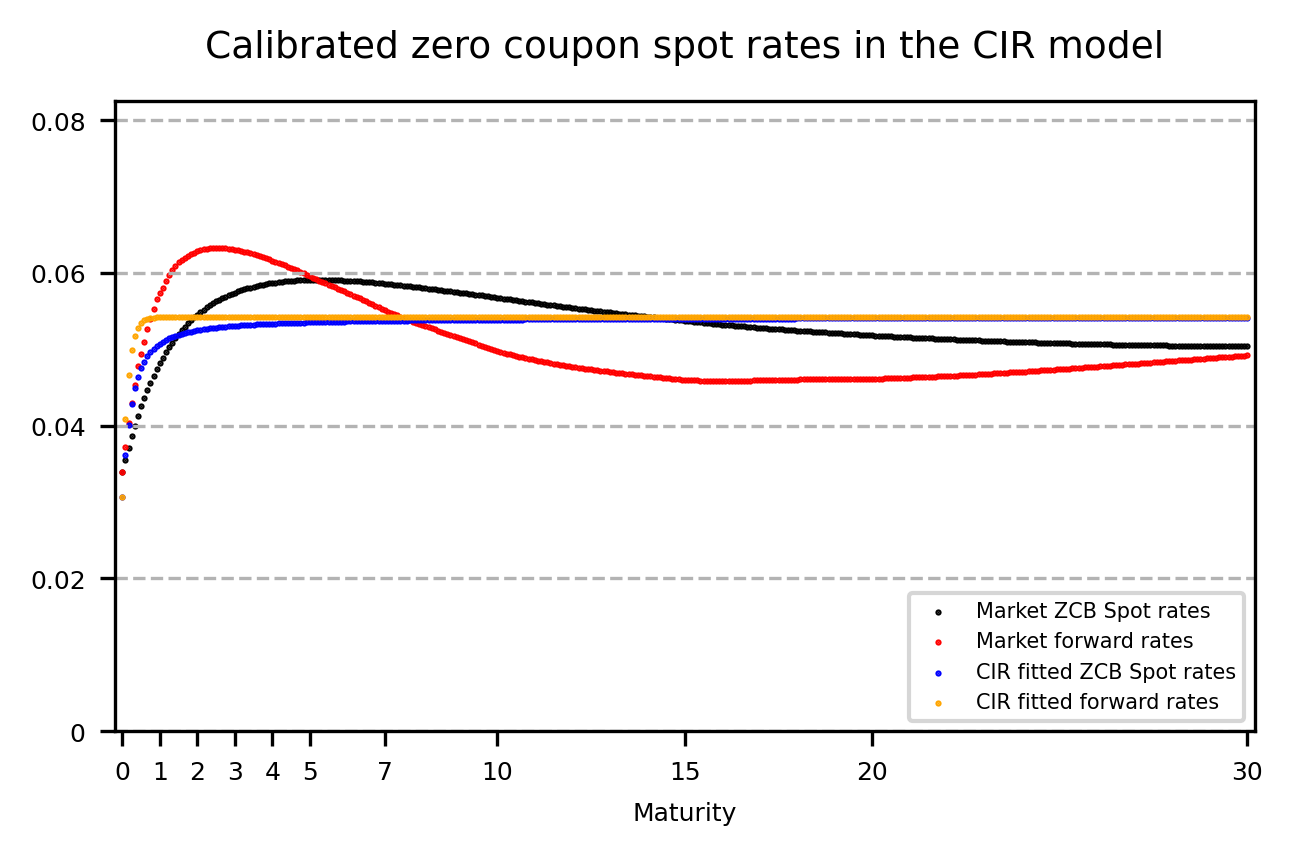

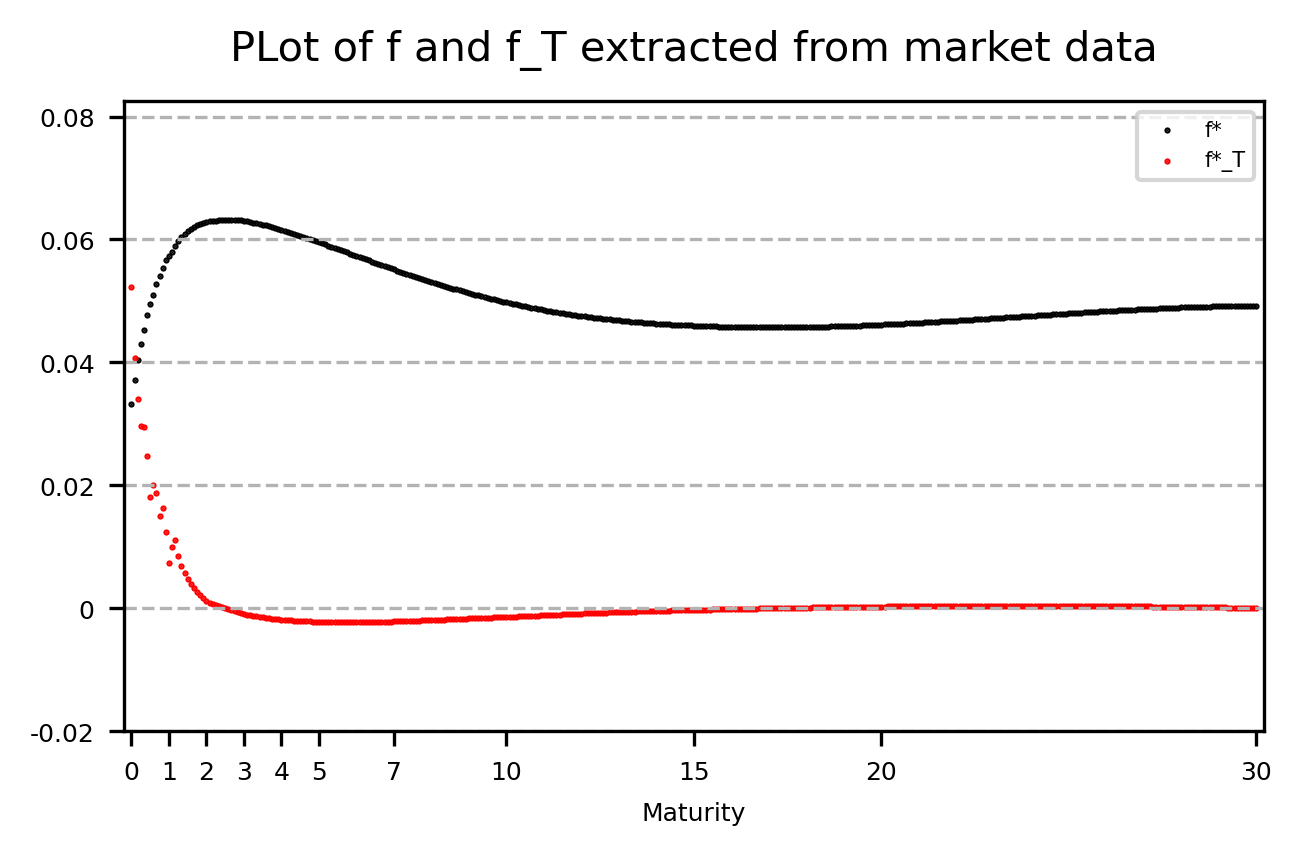

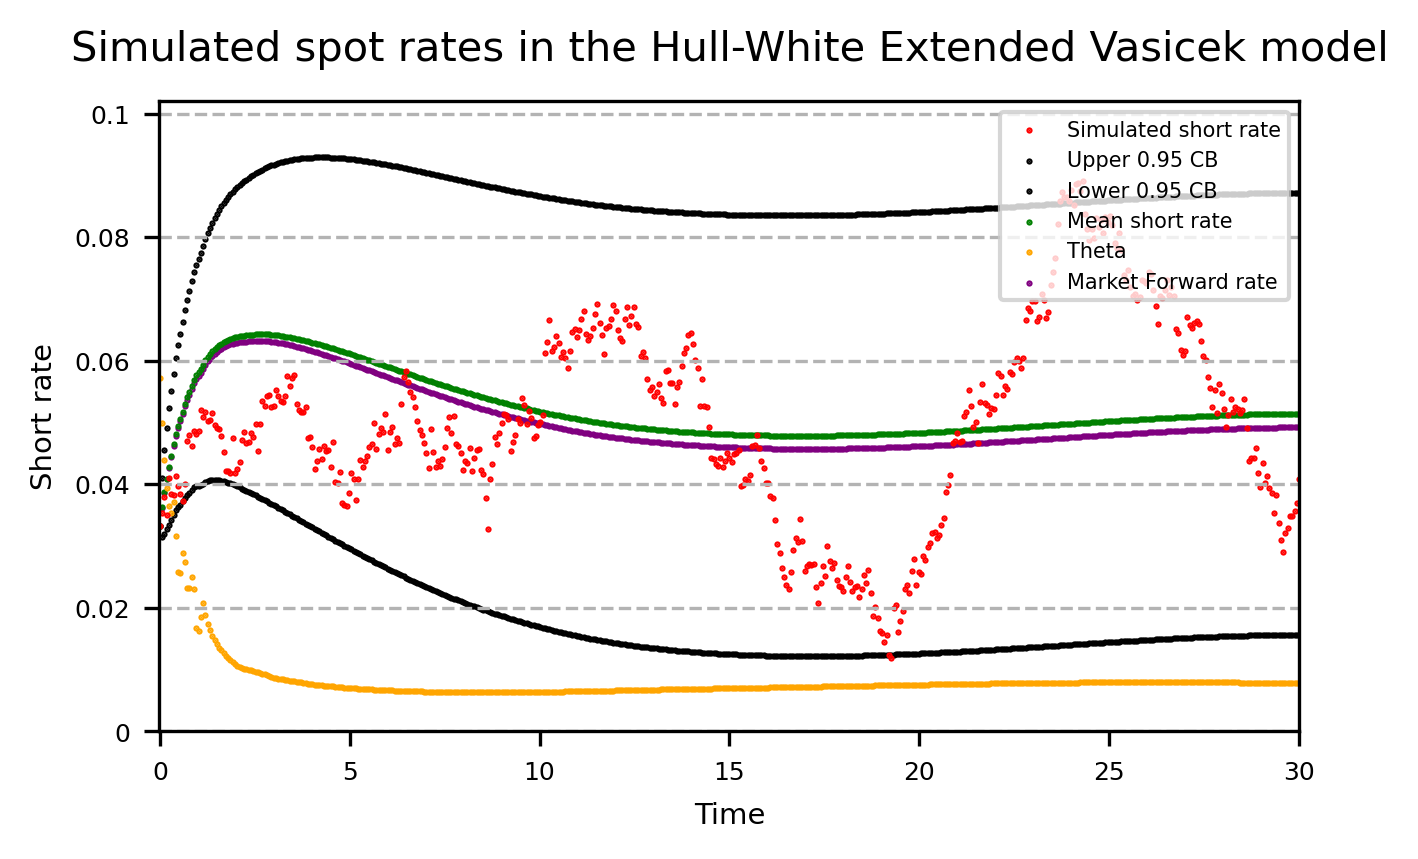

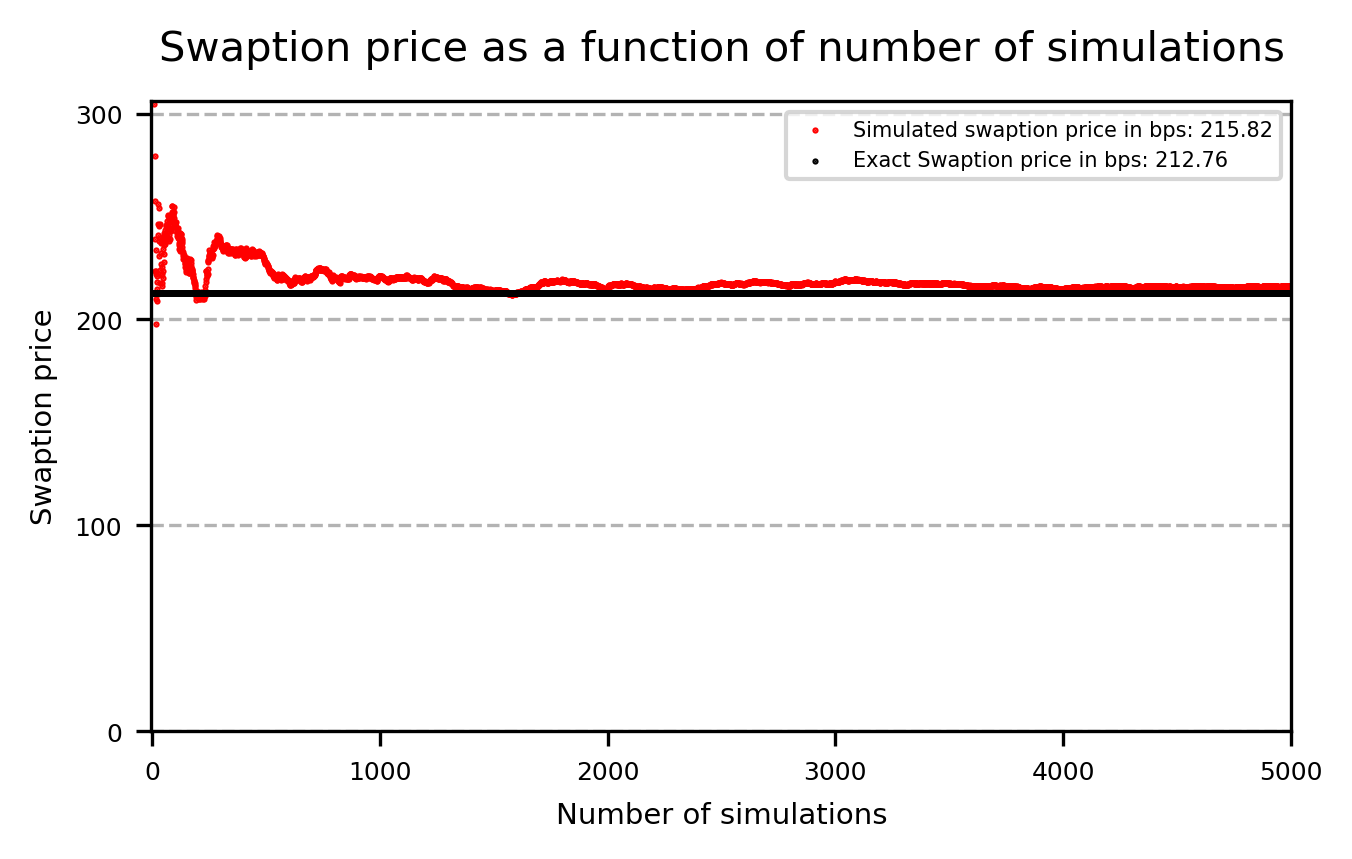

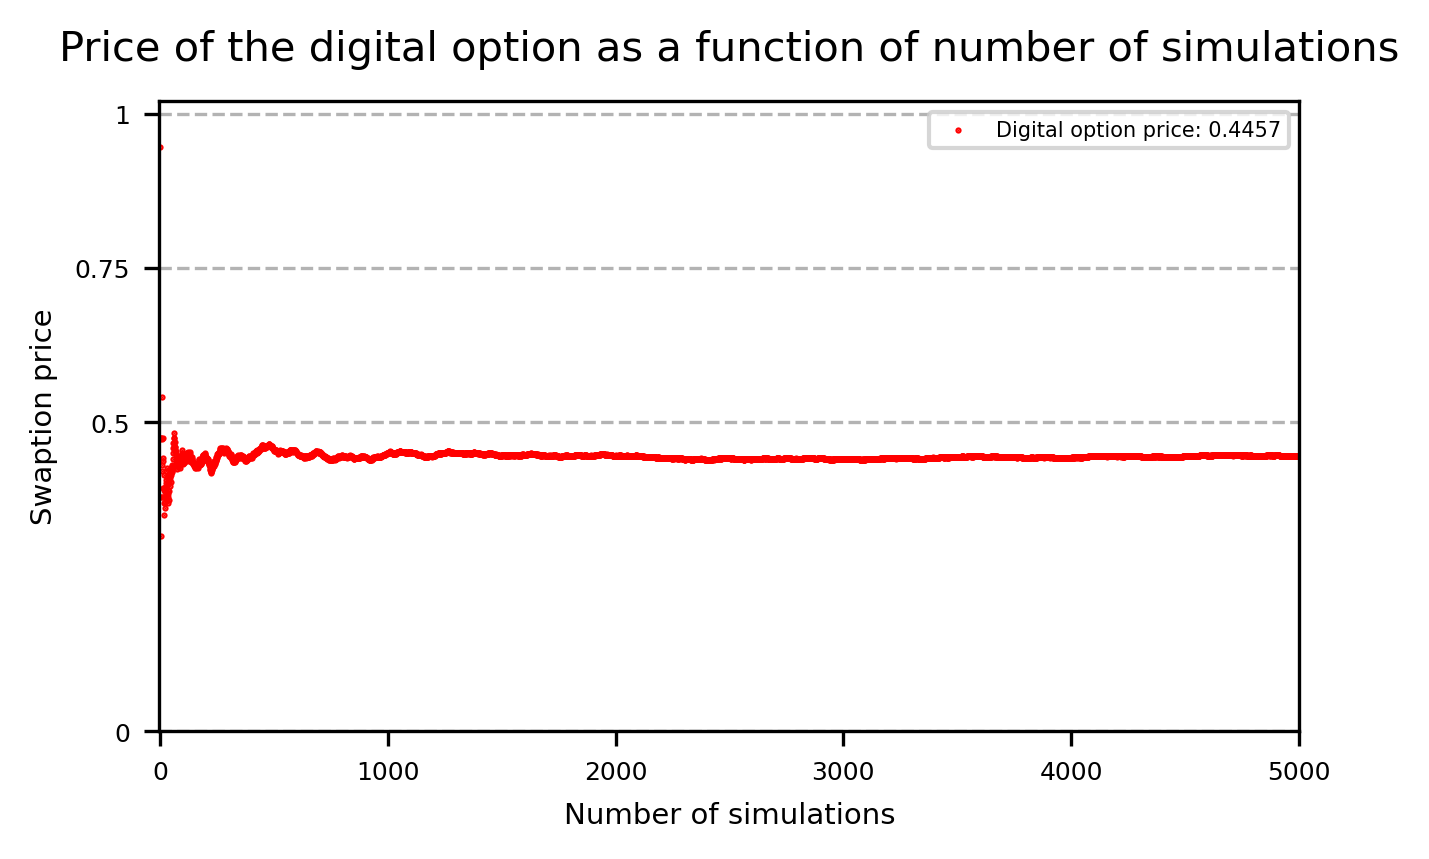

In [10]:
# PLot of ZCB spot and forward rates
fig = plt.figure(constrained_layout = False, dpi = 300, figsize = (5,3))
fig.suptitle(f"", fontsize = 10)
gs = fig.add_gridspec(nrows = 1, ncols = 1, left = 0.12, bottom = 0.2, right = 0.88, top = 0.90, wspace = 0, hspace = 0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T, R_inter, s = 1, color = 'black', marker = ".",label="Market ZCB spot rates")
p2 = ax.scatter(T, f_inter, s = 1, color = 'red', marker = ".",label="Market forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)

# PLot of ZCB spot and forward rates as well as fitted Vasicek rates
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates in the Vasicek model", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter, R_inter, s = 1, color = 'black', marker = ".",label="Market ZCB Spot rates")
p2 = ax.scatter(T_inter, f_inter, s = 1, color = 'red', marker = ".",label="Market forward rates")
p3 = ax.scatter(T_inter, R_vasicek, s = 1, color = 'blue', marker = ".",label="Vasicek fitted ZCB Spot rates")
p4 = ax.scatter(T_inter, f_vasicek, s = 1, color = 'orange', marker = ".",label="Vasicek fitted forward rates")
plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 5)

# PLot of ZCB spot and forward rates as well as fitted Vasicek rates
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates in the CIR model", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter, R_inter, s = 1, color = 'black', marker = ".",label="Market ZCB Spot rates")
p2 = ax.scatter(T_inter, f_inter, s = 1, color = 'red', marker = ".",label="Market forward rates")
p3 = ax.scatter(T_inter, R_cir, s = 1, color = 'blue', marker = ".",label="CIR fitted ZCB Spot rates")
p4 = ax.scatter(T_inter, f_cir, s = 1, color = 'orange', marker = ".",label="CIR fitted forward rates")
plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 5)

# PLot of f and f_T extracted from market data
fig = plt.figure(constrained_layout = False, dpi = 300, figsize = (5,3))
fig.suptitle(f"PLot of f and f_T extracted from market data", fontsize = 10)
gs = fig.add_gridspec(nrows = 1, ncols = 1, left = 0.12, bottom = 0.2, right = 0.88, top = 0.90, wspace = 0, hspace = 0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([-0.02,0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([-0.02,0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([-0.02,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T, f_star, s = 1, color = 'black', marker = ".",label="f*")
p2 = ax.scatter(T, f_T_star, s = 1, color = 'red', marker = ".",label="f*_T")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
# plt.show()

# PLot of simulated short rates in the HWEV model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated spot rates in the Hull-White Extended Vasicek model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,5,10,15,20,25,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p2 = ax.scatter(t_simul, ub, s = 1, color = 'black', marker = ".",label=f"Upper {size_ci} CB")
p3 = ax.scatter(t_simul, lb, s = 1, color = 'black', marker = ".",label=f"Lower {size_ci} CB")
p6 = ax.scatter(t_simul, f_market, s = 1, color = 'purple', marker = ".",label=f"Market Forward rate")
p4 = ax.scatter(t_simul, mean_hwev, s = 1, color = 'green', marker = ".",label=f"Mean short rate")
p5 = ax.scatter(t_simul, theta, s = 1, color = 'orange', marker = ".",label=f"Theta")
p1 = ax.scatter(t_simul, r_simul, s = 1, color = 'red', marker = ".",label="Simulated short rate")
plots = [p1,p2,p3,p4,p5,p6]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)

# Plot of the swaption price as a function of N_simul
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Swaption price as a function of number of simulations",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,int((1/5)*N_simul_swaption),int((2/5)*N_simul_swaption),int((3/5)*N_simul_swaption),int((4/5)*N_simul_swaption),int(N_simul_swaption)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-2,xticks[-1]+2])
plt.xlabel(f"Number of simulations",fontsize = 7)
yticks1 = [0,100,200,300]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Swaption price",fontsize = 7)
p1 = ax.scatter([i for i in range(1,N_simul_swaption+1)], price_swaption_plot, s = 1, color = 'red', marker = ".",label=f"Simulated swaption price in bps: {np.round(price_swaption_plot[-1],2)}")
p2 = ax.scatter([i for i in range(1,N_simul_swaption+1)], 10000*price_swaption_explicit*np.ones([N_simul_swaption]), s = 1, color = 'black', marker = ".",label=f"Exact Swaption price in bps: {np.round(10000*price_swaption_explicit,2)}")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)

# Plot of the digital option price as a function of N_simul
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Price of the digital option as a function of number of simulations",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,int((1/5)*N_simul_digital),int((2/5)*N_simul_digital),int((3/5)*N_simul_digital),int((4/5)*N_simul_digital),int(N_simul_digital)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-2,xticks[-1]+2])
plt.xlabel(f"Number of simulations",fontsize = 7)
yticks1 = [0,25,0.5,0.75,1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Swaption price",fontsize = 7)
p1 = ax.scatter([i for i in range(1,N_simul_digital+1)], price_digital_plot, s = 1, color = 'red', marker = ".",label=f"Digital option price: {np.round(price_digital_plot[-1],4)}")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()
